The goal is to interpret the cryptomarket with the help of a 2D map & overlay network generated with affinity propagation, a better clustering technique compared to Kmeans clustering.

Clustering is an unsupervised learning tefchnique that aims to group similar objects into clusters while separating from different 
objects.Crypto being filled with real word data, prototype based clustering approaches are not the best approach given that the number of clusters is unknown and difficult to guess which is why we rely on affinity propagation an approach that automatically estimate the number of clusters. 

Affinity propagation identifies clusters by comparing data point with one another by measuring similarities, this approach selects cluster centers that represent other surrounding data points.

The clusters reveal the cryptocurrencies that have experienced similary price actions in the past 50 days.

This is useful in order to evaluate market risk of a given portfolio by visualizing the digital assets on a map!

***
Make sure to have cmcScraper (pip install cryptocmd), pandas, NumPy, matplotlib & Seaborn installed

In [11]:
# pip install cryptocmd

STEPS:

1/ Defining a list of cryptocurrencies of interest and download their price data from coinmarketcap using cmcscraper

2/ Visualizing the historical price data for better understanding

3/ Preparing and cleaning the data before clustering

4/ Affinity propagation to cluster

5/ Calculating covariances matrixes between clusters

6/ Arranging cryptocurrencies on 2D map to create a network overlay based on covariance

7/ Interpreting the crypto market map

In [12]:
from cryptocmd import CmcScraper
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import cluster, covariance, manifold

#List of cryptos we are considering for our research

# This list defines the coins that will be considered
symbol_dict = {
    'BTC': 'Bitcoin',
    'BCH':'Bitcoin Cash',
    'ETH': 'Ethereum',
    'XRP': 'Ripple',
    'ADA': 'Cardano',
    'KMD': 'Komodo',
    'BNB': 'Binance Coin',
    'DOGE': 'Doge Coin',
    'LTC': 'Litecoin',
    'USDT': 'Tether',
    'ZRX': 'Zer0',
    'BAT': 'Battoken',
    'UNI': 'DOT',
    'PSG': 'PSG Token',
    'ACM': 'ACM Token',
    'RSR': 'AS Rom Token',
    'JUV': 'Juventus Turin Token',
    'ATM': 'Atletico Madrid Token',
    'SOL': 'Solana', 
    'MATIC': 'Polygon', 
    'LINK': 'Link',
    'ETC': 'Ethereum Classic',
    'AVAX': 'Avalance', 
    'DCR': 'Decred',
    'WAVES': 'WAVES',
    'VET': 'Vechain', 
    'ARK': 'ARK',
    'BCH': 'Bitcoin Cash',
    'ICP': 'Internet Computer',
    'DGB': 'Digibyte',
   'BTT': 'BitTorrent',
    'CEL': 'Celsius',
    'SNX': 'Synthetix', 
    'ENJ': 'Enjin',
    'ZIL': 'Zilliqa', 
    'CHZ': 'Chilliz',
    'THETA': 'Theta',
    'XLM': 'Stellar Lumen',
    'SYS': 'Sys Coin',
    'LRC': 'Loopring',
    'RLC': 'LRC',
    'EOS': 'EOS',
    'NEO': 'NEO',
    'MIOTA': 'IOTA',
    'CAKE': 'Cake Defi',
    'BLZ': 'BLZ',
    'XMR': 'Monero',
    'FORTH': 'Ampleforth',
    'LUNA' : 'Terra Luna',
    'UST' : 'USD Luna',
    'BNT':'Bancor',
    'LDO': 'Lido Network'

}

In [13]:
#Downloading crypto price using Coin Market Cap SCRAPER CmcScraper

def load_fresh_data_and_save_to_disc(symbol_dict, save_path):
    symbols, names = np.array(sorted(symbol_dict.items())).T
    for symbol in symbols:

        scraper = CmcScraper(symbol) # Initializing scraper with time Interval

        #Generating a Pandas dataframe for the data fetched above
        df_coin_prices = scraper.get_dataframe()
        df = pd.DataFrame()
        print(f'Fetching prices for {symbol}')
        
        df[symbol + '_Open'] = df_coin_prices['Open']
        df[symbol + '_Close'] = df_coin_prices['Close']
        df[symbol + '_Avg'] = (df_coin_prices['Close'] + df_coin_prices['Open']) / 2

        #Daily price fluctuation in %
        df[symbol + '_p'] = (df_coin_prices['Open'] - df_coin_prices['Close'] )/ df_coin_prices['Open']

        if symbol == symbols[0]:
            df_crypto = df.copy()
        else:
            df_crypto = pd.merge(
                left=df_crypto, right=df, how = "outer",
                left_index = True, right_index= True)
        filter_columns = [s for s in df_crypto.columns if '_p' in s]
        X_df_filtered = df_crypto[filter_columns].copy()
    X_df_filtered.to_csv(save_path + 'historical_crypto_prices.csv')
    return names, symbols, X_df_filtered
save_path = ''

new_data = True
if new_data == False:
    try:
        print("Loading from disk")
        X_df_filtered = pd.read_csv(save_path + 'historical_crypto_prices.csv')
        if 'Unnamed: 0' in X_df_filtered.columns:
            X_df_filtered = X_df_filtered.drop(['Unnamed: 0'], axis = 1)
            symbols, names = np.array(sorted(symbol_dict.items())).T
        print(list(X_df_filtered.columns))
    except:
        print('No existing price data found - loading fresh data from CMC then saving to disk.')
        names, symbols, X_df_filtered = load_fresh_data_and_save_to_disc(symbol_dict, save_path)
        print(list(symbols))
else:
    print('Loading fresh data from CMC and saving to disk.')
    names, symbols, X_df_filtered = load_fresh_data_and_save_to_disc(symbol_dict, save_path)
    print(list(symbols))

#Limiting Price Data for last t days
t = 50
X_df_filtered = X_df_filtered[:t]
X_df_filtered.head()

Loading fresh data from CMC and saving to disk.
Fetching prices for ACM
Fetching prices for ADA
Fetching prices for ARK
Fetching prices for ATM
Fetching prices for AVAX
Fetching prices for BAT
Fetching prices for BCH
Fetching prices for BLZ
Fetching prices for BNB
Fetching prices for BNT
Fetching prices for BTC
Fetching prices for BTT
Fetching prices for CAKE
Fetching prices for CEL
Fetching prices for CHZ
Fetching prices for DCR
Fetching prices for DGB
Fetching prices for DOGE
Fetching prices for ENJ
Fetching prices for EOS
Fetching prices for ETC
Fetching prices for ETH
Fetching prices for FORTH
Fetching prices for ICP
Fetching prices for JUV
Fetching prices for KMD
Fetching prices for LDO
Fetching prices for LINK
Fetching prices for LRC
Fetching prices for LTC
Fetching prices for LUNA
Fetching prices for MATIC
Fetching prices for MIOTA
Fetching prices for NEO
Fetching prices for PSG
Fetching prices for RLC
Fetching prices for RSR
Fetching prices for SNX
Fetching prices for SOL
Fetch

,ACM_p,ADA_p,ARK_p,ATM_p,AVAX_p,BAT_p,BCH_p,BLZ_p,BNB_p,BNT_p,...,UNI_p,USDT_p,UST_p,VET_p,WAVES_p,XLM_p,XMR_p,XRP_p,ZIL_p,ZRX_p
0,-0.000303,-0.031135,-0.007955,-0.017351,-0.063957,-0.039065,-0.045975,-0.035442,-0.068624,-0.021155,...,-0.004325,0.000154,0.007481,-0.016354,0.046299,-0.041956,0.068786,-0.043021,-0.082476,-0.005889
1,0.181343,0.175009,0.159328,0.147999,0.185389,0.171756,0.151965,0.212446,0.157659,0.123793,...,0.148925,-0.000039,0.202962,0.134970,0.031744,0.116020,0.192729,0.129879,0.175689,0.190322
2,0.050662,0.029513,0.057140,0.025115,0.065727,0.020288,0.025756,0.035881,0.028256,0.032781,...,0.009334,0.000065,0.000508,0.026725,0.023537,0.035310,-0.063473,0.027252,-0.008233,0.065065
3,-0.019350,0.027409,0.038733,0.005294,0.032940,0.040592,0.022718,0.045642,0.035867,0.028281,...,0.053998,0.000050,0.003019,0.030052,0.063674,0.021515,0.060072,0.033548,0.062274,0.049042
4,0.020506,0.009741,0.031311,0.021159,0.035297,0.012392,0.008263,-0.011075,-0.001446,0.007700,...,-0.036080,0.000008,0.000204,0.012235,-0.027051,-0.000210,-0.050182,-0.006242,-0.033801,0.020149


Data Visualization, line graphs.

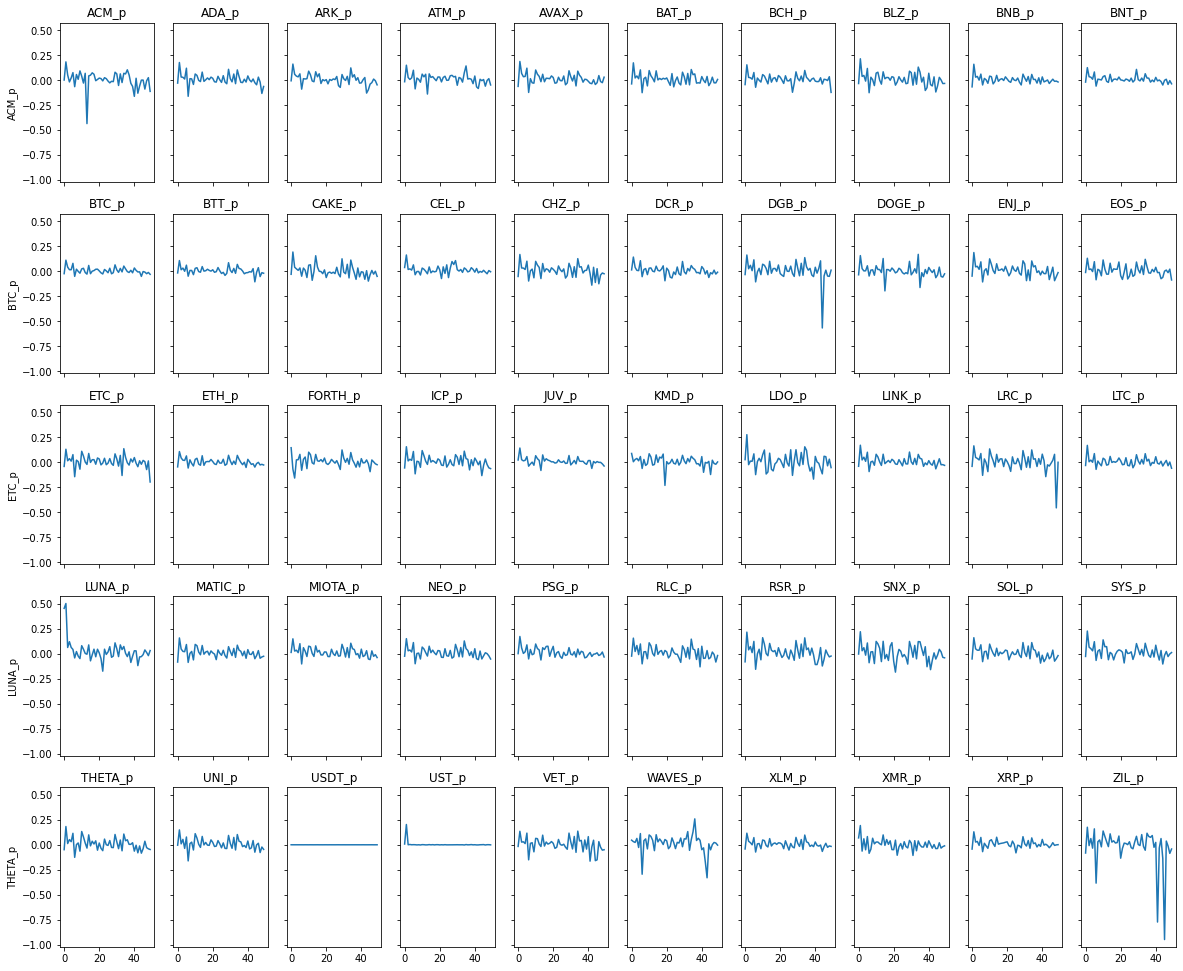

In [14]:
# Create Prices Charts for all Cryptocurrencies
list_length = X_df_filtered.shape[1]
ncols = 10
nrows = int(round(list_length / ncols, 0))
height = list_length/3 if list_length > 30 else 4

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(20, height))
for i, ax in enumerate(fig.axes):
        if i < list_length:
            sns.lineplot(data=X_df_filtered, x=X_df_filtered.index, y=X_df_filtered.iloc[:, i], ax=ax)
            ax.set_title(X_df_filtered.columns[i])
plt.show()

In [15]:
#Dropping NAN Values

X_df = pd.DataFrame(np.array(X_df_filtered)).dropna()

X = X_df.copy()
X /= X.std(axis = 0)
X = np.array(X)

edge_model = covariance.GraphicalLassoCV()
edge_model.fit(X)

#Grouping cryptos into Clusters using Affinity Propagation

cluster_centers_indices, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=1)
cluster_dict = {}
n_labels = labels.max()
print(f"{n_labels} Clusters")

for i in range(n_labels + 1):
    clusters = ', '.join(names[labels == i])
    print('Cluster %i: %s' %((i + 1), clusters))
    cluster_dict[i] = (clusters)

14 Clusters
Cluster 1: ACM Token
Cluster 2: Celsius
Cluster 3: Doge Coin
Cluster 4: Ampleforth
Cluster 5: Komodo
Cluster 6: Cardano, ARK, Avalance, Battoken, Binance Coin, Bancor, Bitcoin, BitTorrent, Cake Defi, Decred, Digibyte, Enjin, Ethereum, Internet Computer, Juventus Turin Token, Lido Network, Link, Litecoin, Polygon, PSG Token, AS Rom Token, Solana, Sys Coin, Theta, DOT, Stellar Lumen, Ripple
Cluster 7: Loopring
Cluster 8: Terra Luna
Cluster 9: Atletico Madrid Token, Bitcoin Cash, BLZ, Chilliz, EOS, Ethereum Classic, IOTA, NEO, LRC, Synthetix, Vechain
Cluster 10: Tether
Cluster 11: USD Luna
Cluster 12: WAVES
Cluster 13: Monero
Cluster 14: Zilliqa
Cluster 15: Zer0


Affinity Propagation for Clustering Cryptocurrencies:
-first, we must prepare the data because Affinity Prog is sensitive to NaN values
-the following code will convert the Dataframe into a NumPy array
-the array is then transposed in a shape where crypto assets are rows and days are columns
-the final output is a dictionary of clusters as defined/revealed by the Affinity Propagation Algorithm.

In [16]:
node_position_model = manifold.LocallyLinearEmbedding(n_components=2, eigen_solver= 'dense', n_neighbors=20)
embedding = node_position_model.fit_transform(X.T).T

pd.DataFrame(embedding)

partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))

partial_correlations *= d
partial_correlations *= d[:, np.newaxis]

non_zero = (np.abs(np.triu(partial_correlations, k = 1)) > 0.02)
data = pd.DataFrame.from_dict({"embedding_x":embedding[0], "embedding_y":embedding[1]})

data['labels'] = labels
print(data.shape)
data.head()



(51, 3)


,embedding_x,embedding_y,labels
0,0.370715,0.239026,0
1,-0.101992,-0.023475,5
2,-0.029038,0.028132,5
3,0.198538,0.074400,8
4,-0.096741,-0.049995,5


Visualizing the Crypto Market Structure by clusters.

<AxesSubplot:ylabel='Count'>

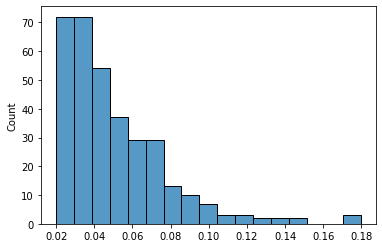

In [17]:
start_idx, end_idx = np.where(non_zero)
segments = [[np.array([embedding[:, start], embedding[:, stop]]).T, start, stop] for start, stop in zip(start_idx, end_idx)]

pc =np.abs(partial_correlations[non_zero])
normalized = (pc - min(pc) ) / (max(pc) - min(pc))
sns.histplot(pc)

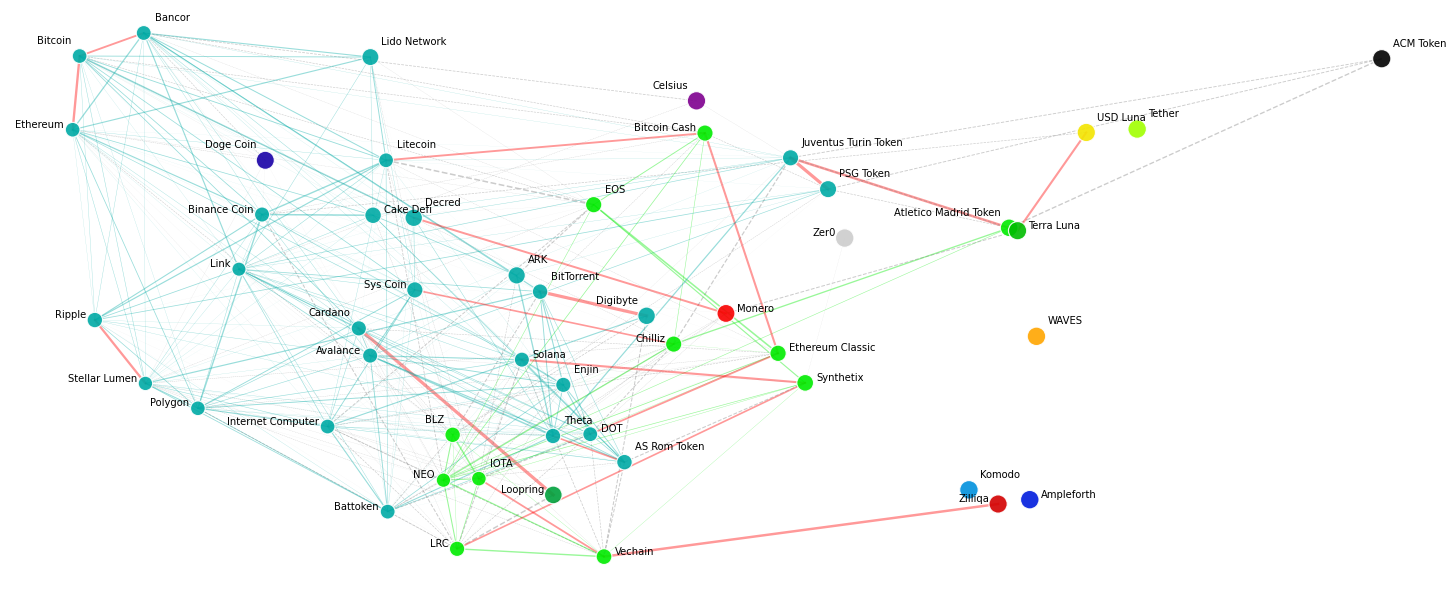

In [19]:
plt.figure(1, facecolor= 'w', figsize=(20,8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])

sc = sns.scatterplot(data = data, x = "embedding_x", y = 'embedding_y', zorder = 1, s = 350 * d ** 2, c = labels, cmap = plt.cm.nipy_spectral, alpha = .9, palette = "muted")
line_strength = 3.2

for index, ((x,y), start, stop) in enumerate(segments):
    norm_partial_correlation = normalized[index]
    if list(data.iloc[[start]]['labels'])[0] == list(data.iloc[[stop]]['labels'])[0]:
        if norm_partial_correlation > 0.5:
            color = 'red'; linestyle = 'solid'
        else:
            color = plt.cm.nipy_spectral(list(data.iloc[[start]]['labels'])[0] / float(n_labels)); linestyle = 'solid'
    else:
        if norm_partial_correlation > 0.5:
            color = 'red'; linestyle = 'solid'
        else:
            color = 'grey'; linestyle = 'dashed'
    plt.plot(x, y, alpha = 0.4, zorder = 0, linewidth = normalized[index] * line_strength, color = color, linestyle = linestyle)

for index, (name, label, (x,y)) in enumerate(zip(names, labels, embedding.T)):
    dx = x - embedding[0]
    dy = y - embedding[1]
    dy[index], dx[index] = 1, 1

    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]

    if this_dx > 0 :
        horizontalalignment = 'left'
        x = x + .005
    else: 
        horizontalalignment = 'right'
        x = x - .004

    if this_dy > 0 :
        verticalalignment = 'bottom'
        y = y + .01
    else:
        verticalalignment = 'top'
        y = y + .01

    plt.text(x, y, name, size = 10,
            horizontalalignment = horizontalalignment, 
            verticalalignment = verticalalignment)
plt.axis('off')
plt.show()


